In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
from dotenv import load_dotenv

load_dotenv();

### Generate a random Hamiltonian instance

* In this example, we generate a random Sherrington-Kirkpatrick Hamiltonian.
* In general, we can generate other classes, or read the instances from file.
* We can also solve the Hamiltonian classicaly, to get the ground state energy and the highest energy. (this, of course, should be done offline, before running the QAOA)


In [3]:
from quapopt.hamiltonians.generators import build_hamiltonian_generator
from quapopt.data_analysis.data_handling import (CoefficientsType,
                                                 CoefficientsDistribution,
                                                 CoefficientsDistributionSpecifier,
                                                 HamiltonianModels)

number_of_qubits = 5
seed_cost_hamiltonian = 1

coefficients_type = CoefficientsType.DISCRETE
coefficients_distribution = CoefficientsDistribution.Uniform
coefficients_distribution_properties = {'low': -1, 'high': 1, 'step': 1}
coefficients_distribution_specifier = CoefficientsDistributionSpecifier(CoefficientsType=coefficients_type,
                                                                        CoefficientsDistributionName=coefficients_distribution,
                                                                        CoefficientsDistributionProperties=coefficients_distribution_properties)

# We generate a Hamiltonian instance. In this case it's a random Sherrington-Kirkpatrick Hamiltonian
hamiltonian_model = HamiltonianModels.SherringtonKirkpatrick
localities = (1, 2)
generator_cost_hamiltonian = build_hamiltonian_generator(hamiltonian_model=hamiltonian_model,
                                                         localities=localities,
                                                         coefficients_distribution_specifier=coefficients_distribution_specifier)

cost_hamiltonian = generator_cost_hamiltonian.generate_instance(number_of_qubits=number_of_qubits,
                                                                seed=seed_cost_hamiltonian,
                                                                read_from_drive_if_present=True)

print("Class description (cost):", cost_hamiltonian.hamiltonian_class_description)
print("Instance description (cost):", cost_hamiltonian.hamiltonian_instance_description)

if cost_hamiltonian.lowest_energy is None:
    print("SOLVING THE HAMILTONIAN CLASSICALLY")
    # if we wish, we can solve the Hamiltonian classically
    cost_hamiltonian.solve_hamiltonian(both_directions=True)

ground_state_energy = cost_hamiltonian.ground_state_energy
highest_energy = cost_hamiltonian.highest_energy

File not found!
FILE NOT FOUND!
Class description (cost): HMN=SK;LOC=(1, 2);CFD=CT~DIS_CDN~UNI_CDP~low~-1_high~1_step~1
Instance description (cost): NOQ=5;HII=1
SOLVING THE HAMILTONIAN CLASSICALLY


### Specify the QAOA ansatz parameters
* The specification aims to be a bit general so in the future we can add more ansatze.

Parameters that are specified include:
1. The phase type; in QAOA, this is just $$exp(-i*H*t)$$
2. The mixer type; in QAOA, RX rotations
3. The qubit routing type. Currently supported Linear Chain SWAP network, Fully Connected topology, or SABRE heuristic for qiskit compilation.
4. For linear chain, optional parameters is "linear_chains_pair_device" -- this is a list of tuples, where each tuple is a pair of qubits that are connected in the device. This is used to build the SWAP network.
5. Gate builder -- this is the class that creates the buidling blocks of the quantum circuit. Here we use logical gates builder
6. Ansatz depth -- the number of layers of the QAOA circuit;
7. Time block size (optional) -- the number of gates in a block. This is a "truncated QAOA" ansatz that our team worked with previously.


In [4]:
from quapopt.circuits.gates.logical.LogicalGateBuilderQiskit import LogicalGateBuilderQiskit
from quapopt.optimization.QAOA import PhaseSeparatorType, MixerType

#gate builder for qiskit
gate_builder = LogicalGateBuilderQiskit()
qaoa_depth = 1

# Parameters of the ansatz
time_block_size = None
phase_separator_type = PhaseSeparatorType.QAOA
mixer_type = MixerType.QAOA


[QuantumRegister(5, 'q')] [ClassicalRegister(5, 'c')]


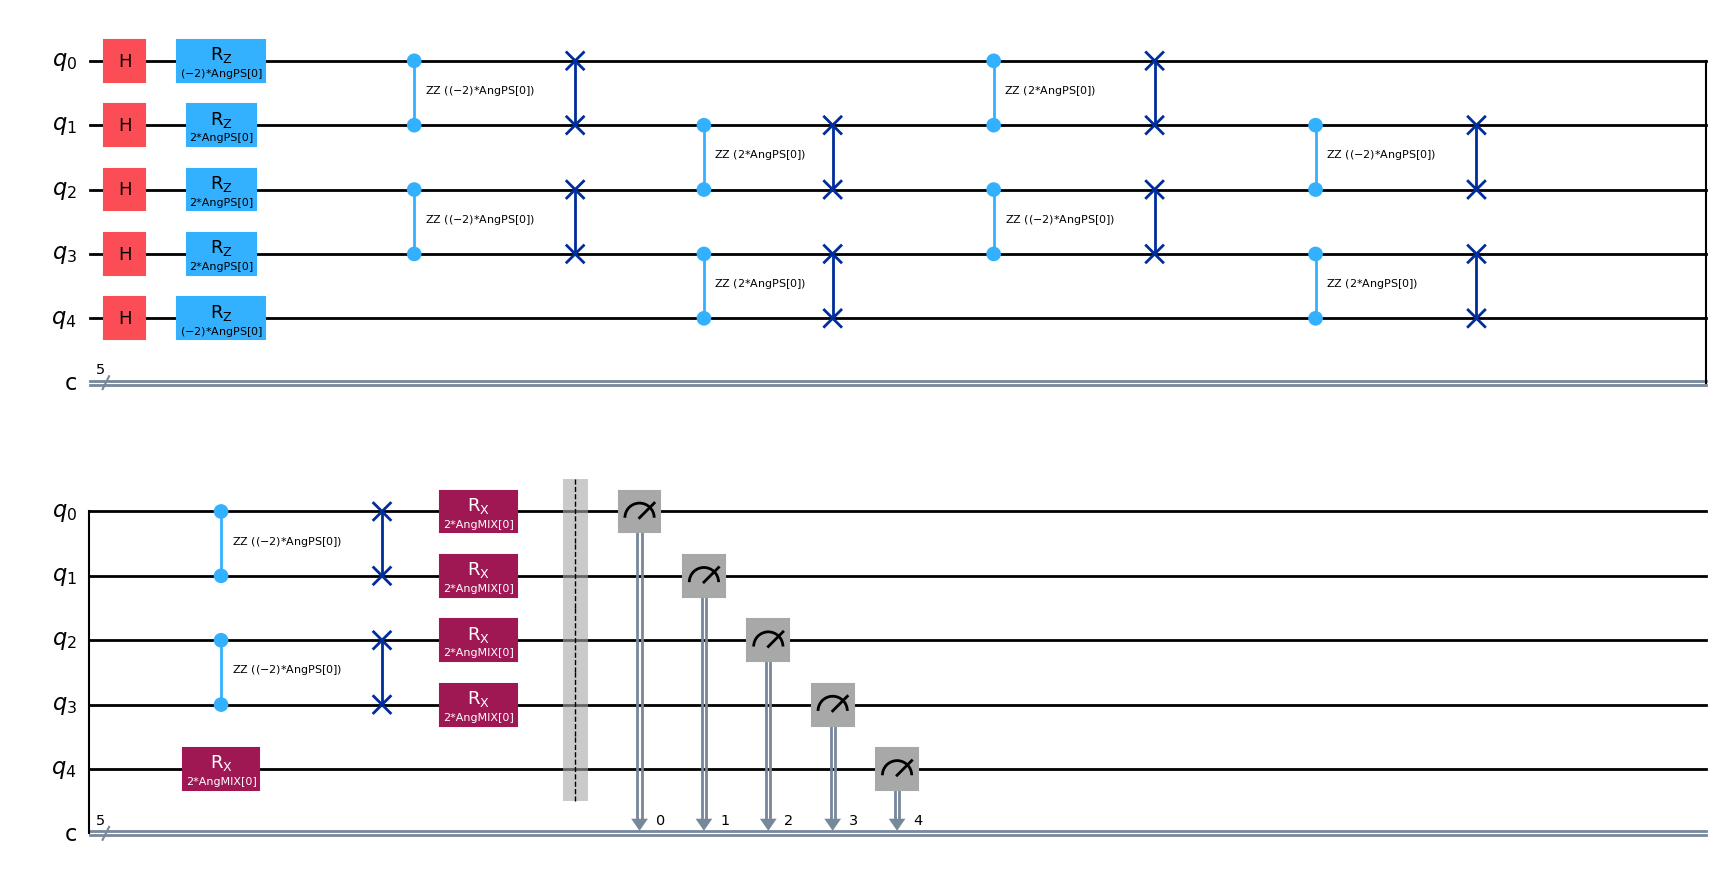

In [5]:
from quapopt.optimization.QAOA.circuits.LinearSwapNetworkQAOACircuit import LinearSwapNetworkQAOACircuit

ansatz_LSN = LinearSwapNetworkQAOACircuit(sdk_name='qiskit',
                                          depth=1,
                                          hamiltonian_phase=cost_hamiltonian,
                                          program_gate_builder=gate_builder,
                                          time_block_size=time_block_size,
                                          phase_separator_type=phase_separator_type,
                                          mixer_type=mixer_type,add_barriers=True)
#the "QAOACircuit" class is a bit more general; it has an attribute that is proper qiskit's circuit
ansatz_circuit_LSN = ansatz_LSN.quantum_circuit
print(ansatz_circuit_LSN.qregs, ansatz_circuit_LSN.cregs)
ansatz_circuit_LSN = gate_builder.add_measurements(quantum_circuit=ansatz_circuit_LSN,
                                                   qubit_indices=list(range(number_of_qubits)),
                                                   classical_indices=list(range(number_of_qubits))
                                                   )
ansatz_circuit_LSN.draw('mpl')

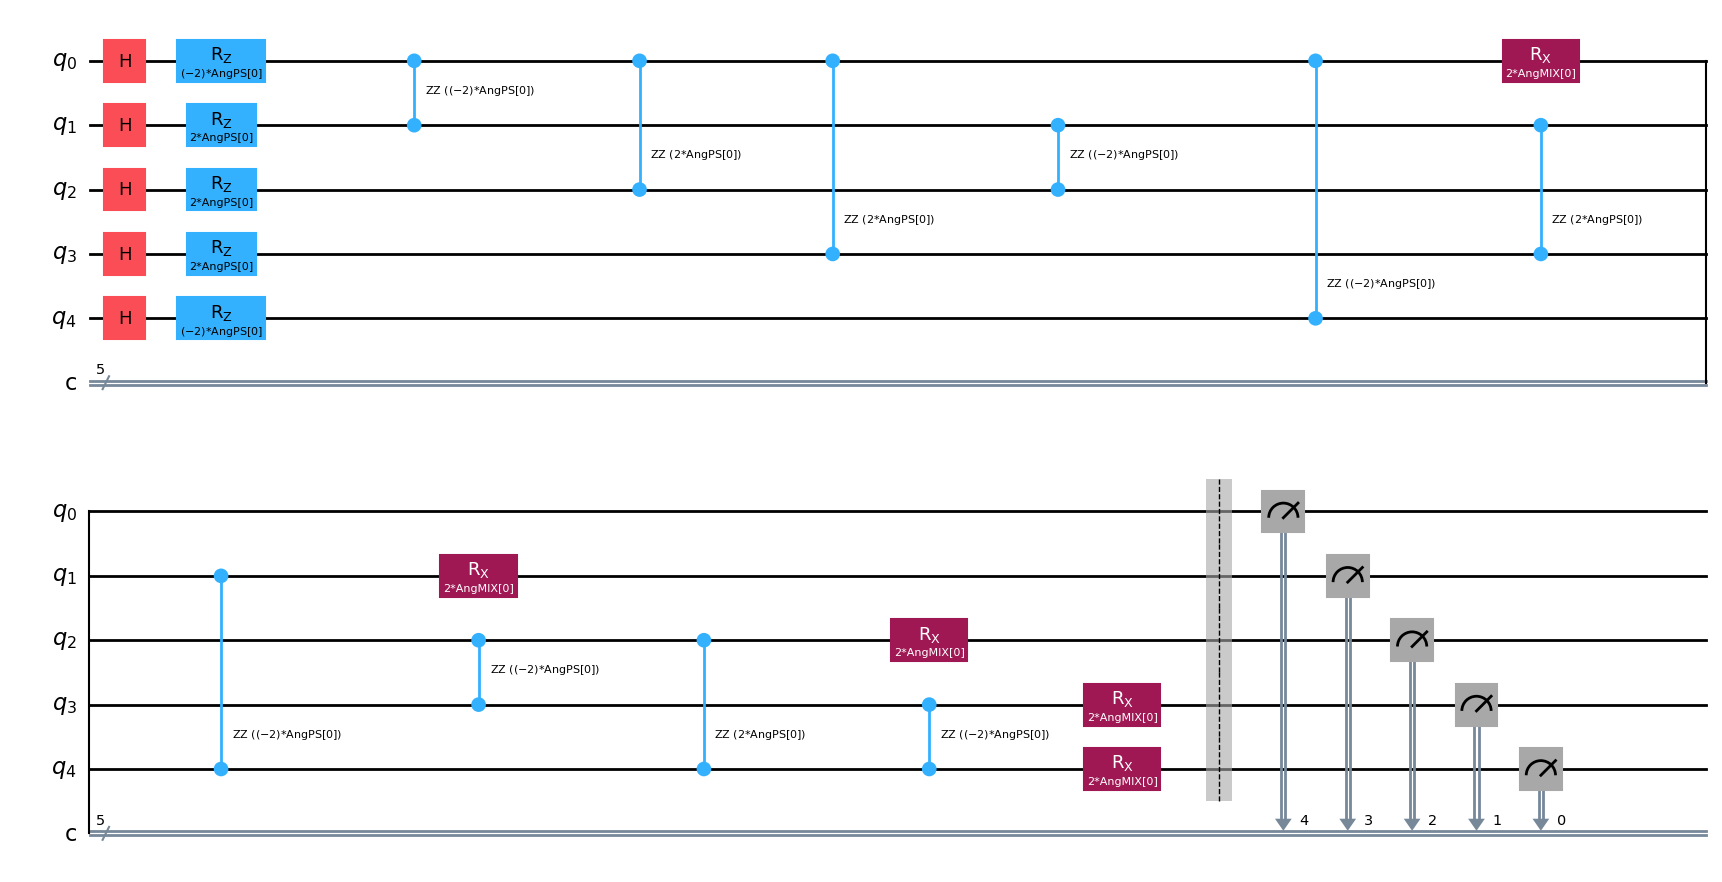

In [6]:
from quapopt.optimization.QAOA.circuits.FullyConnectedQAOACircuit import FullyConnectedQAOACircuit

ansatz_FC = FullyConnectedQAOACircuit(sdk_name='qiskit',
                                      depth=1,
                                      hamiltonian_phase=cost_hamiltonian,
                                      program_gate_builder=gate_builder,
                                      time_block_size=time_block_size,
                                      phase_separator_type=phase_separator_type,
                                      mixer_type=mixer_type,
                                      every_gate_has_its_own_parameter=False,
                                      add_barriers=True)

ansatz_circuit_FC = ansatz_FC.quantum_circuit
ansatz_circuit_FC = gate_builder.add_measurements(quantum_circuit=ansatz_circuit_FC,
                                                  qubit_indices=list(range(number_of_qubits)),
                                                  classical_indices=list(range(number_of_qubits))[::-1]
                                                  )
ansatz_circuit_FC.draw('mpl')


In [7]:
from quapopt.optimization.QAOA.circuits.SabreMappedQAOACircuit import SabreMappedQAOACircuit
from quapopt.optimization.QAOA import QubitMappingType
from quapopt.circuits import backend_utilities as bck_utils

#Change to your actual instance and account name; here we assume it's set in the environment variables
instance_name_ibm = os.getenv('IBM_INSTANCE_NAME')
account_name_ibm = os.getenv('IBM_ACCOUNT_NAME')
credentials_path = os.getenv('IBM_CREDENTIALS_PATH')

#get the provider for the IBM Qiskit backend; we need it to run the SABRE pass manager
provider_ibm = bck_utils.get_qiskit_provider(instance_ibm=instance_name_ibm,
                                             account_name=account_name_ibm,
                                             credentials_path=credentials_path)
#get a default simulator backend and pass manager for the SABRE pass manager
#This can be changed if desired
qiskit_backend, qiskit_pass_manager, pass_manager_kwargs = bck_utils.get_default_qiskit_backend_and_pass_manager(
    provider=provider_ibm,
    backend_name='ibm_pittsburgh', #might change to actual backend for simulation for real device
    qubit_mapping_type=QubitMappingType.sabre,
    backend_kwargs=None,  #use defaults
    pass_manager_kwargs=None,  #use defaults
    )


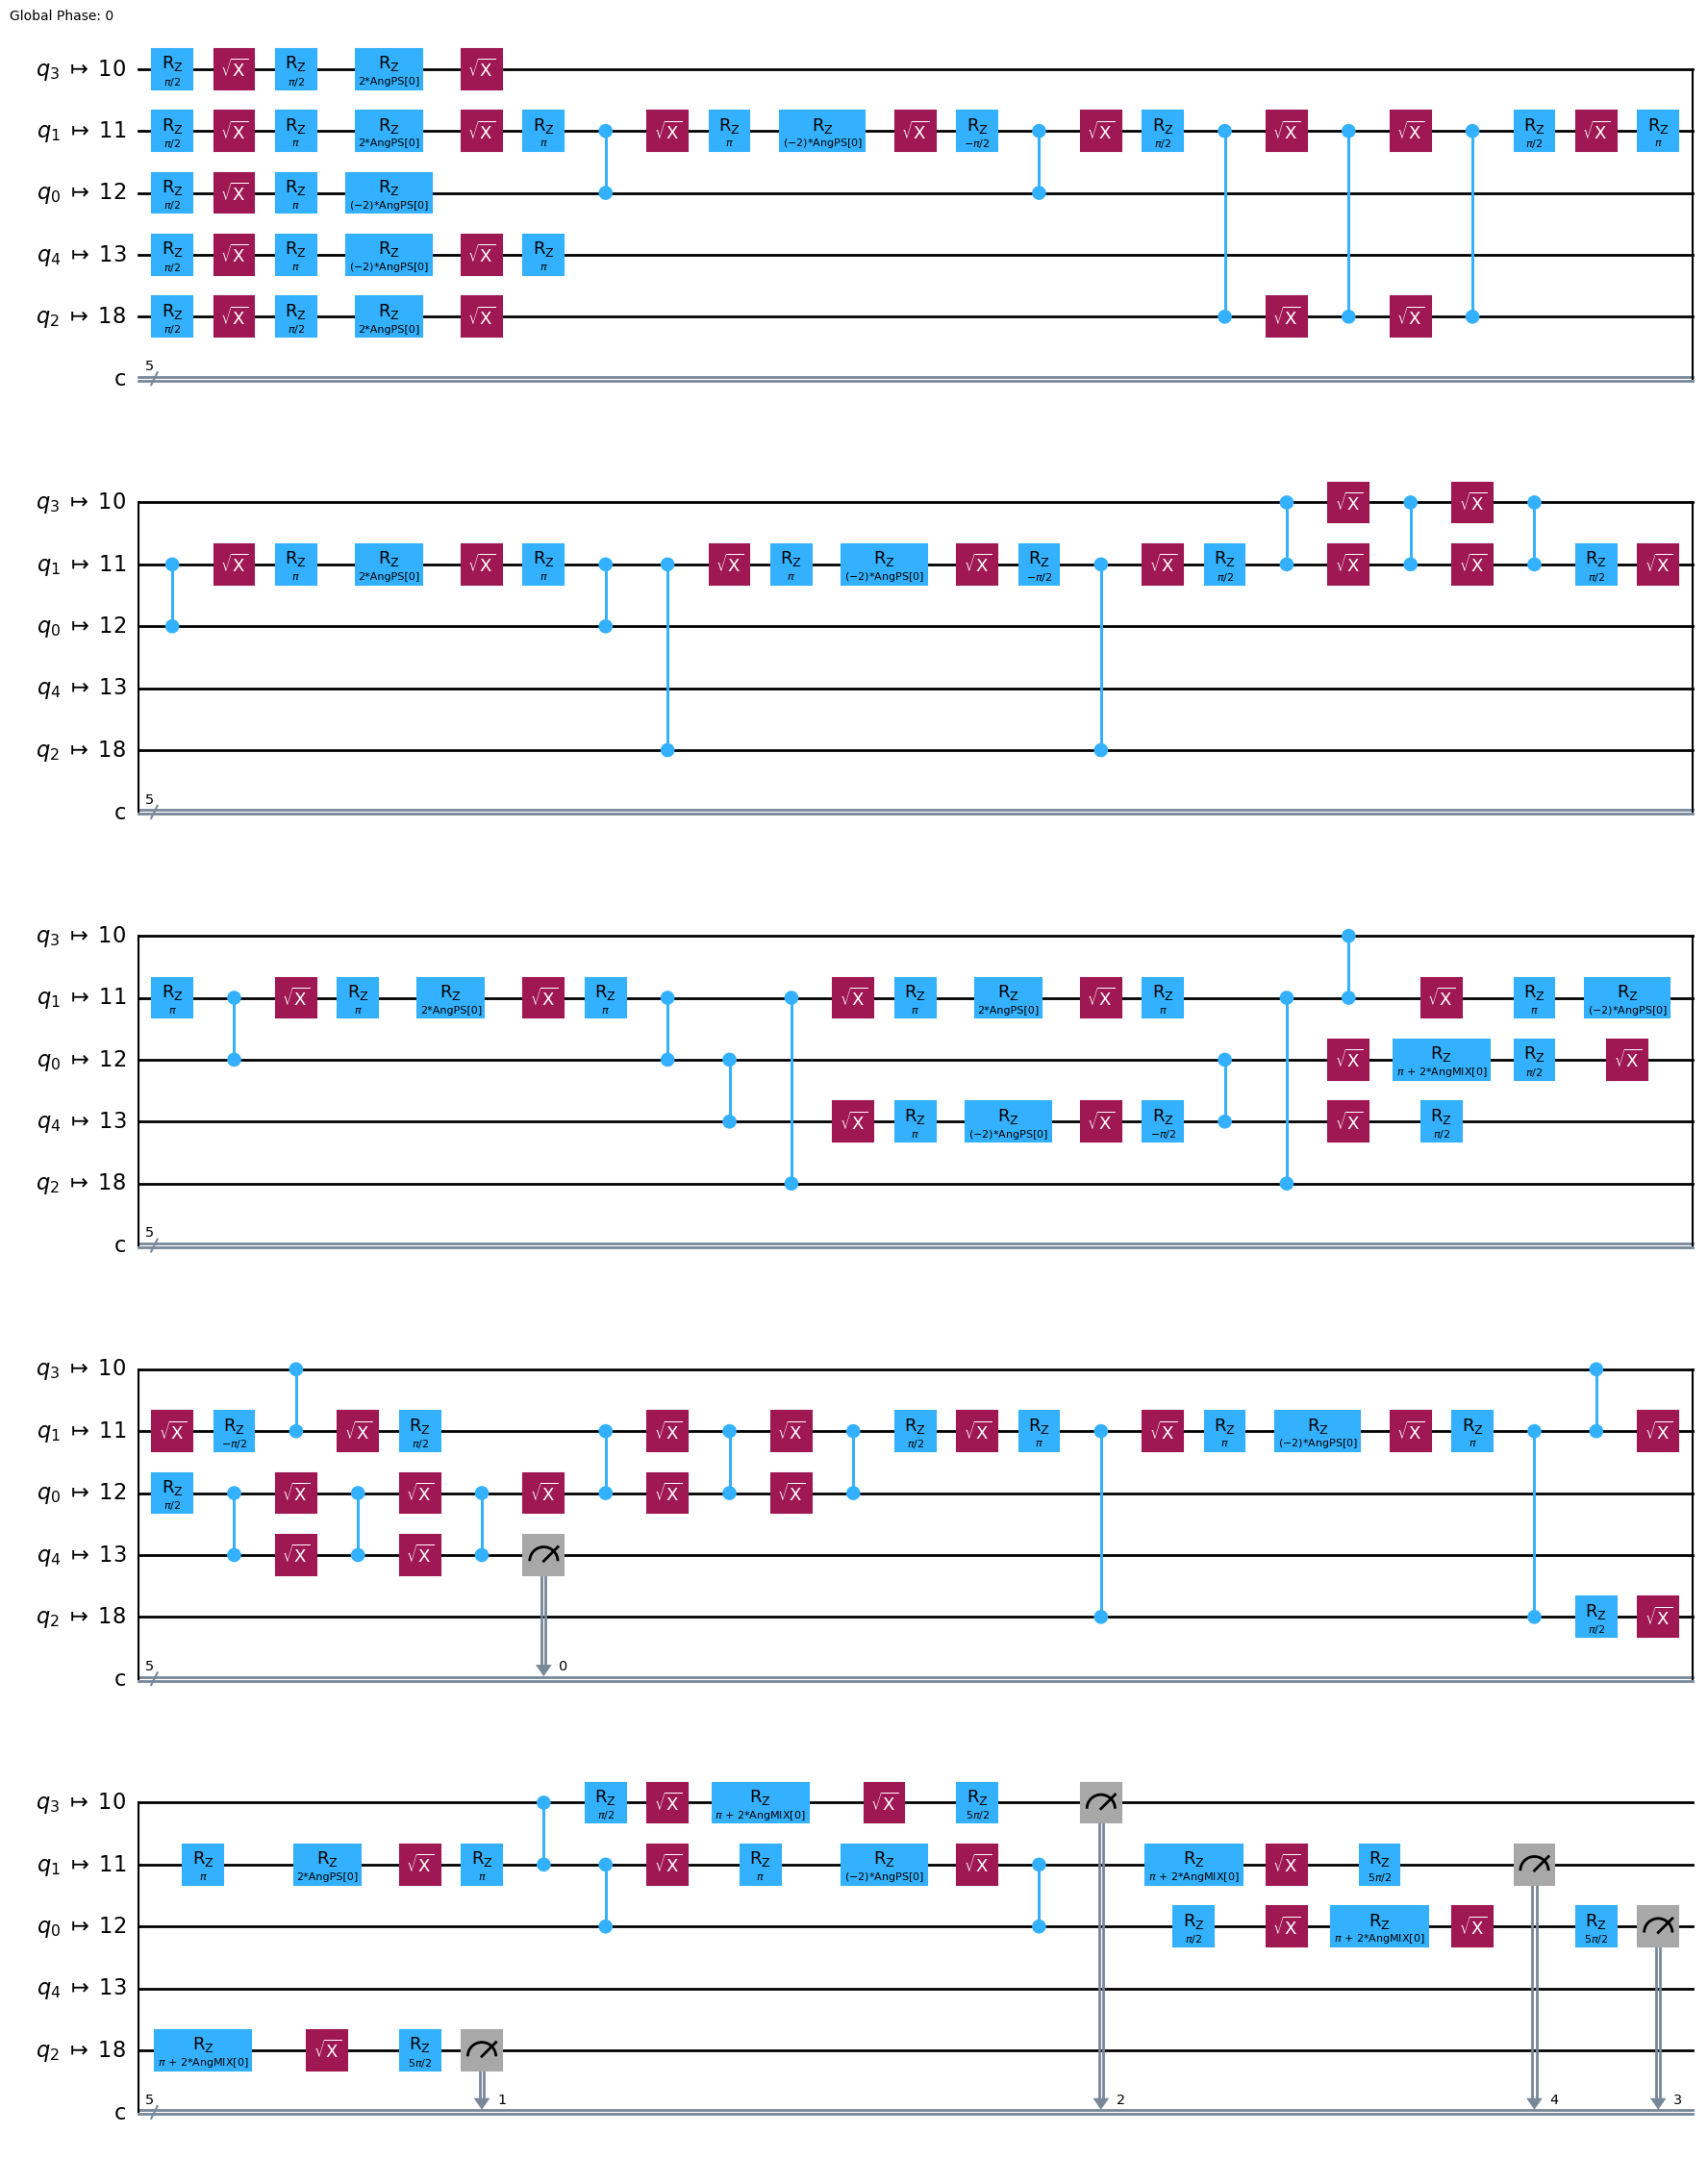

In [8]:
ansatz_SABRE = SabreMappedQAOACircuit(  #sdk_name='qiskit', #sabre is available only for qiskit
    depth=1,
    qiskit_pass_manager=qiskit_pass_manager,
    hamiltonian_phase=cost_hamiltonian,
    program_gate_builder=gate_builder,
    time_block_size=time_block_size,
    phase_separator_type=phase_separator_type,
    mixer_type=mixer_type,
    add_barriers=False # #otherwise, circuit compilation optimization will be hindered
)
ansatz_circuit_SABRE = ansatz_SABRE.quantum_circuit
ansatz_circuit_SABRE = gate_builder.add_measurements(quantum_circuit=ansatz_circuit_SABRE,
                                                     qubit_indices=ansatz_SABRE.logical_to_physical_qubits_map,
                                                     classical_indices=list(range(number_of_qubits))
                                                     )
#if we used real device topology (not aer backend, but real device), SABRE would map the circuit to the device topology
ansatz_circuit_SABRE.draw('mpl')


### Translate the QAOA circuit to an ISA circuit

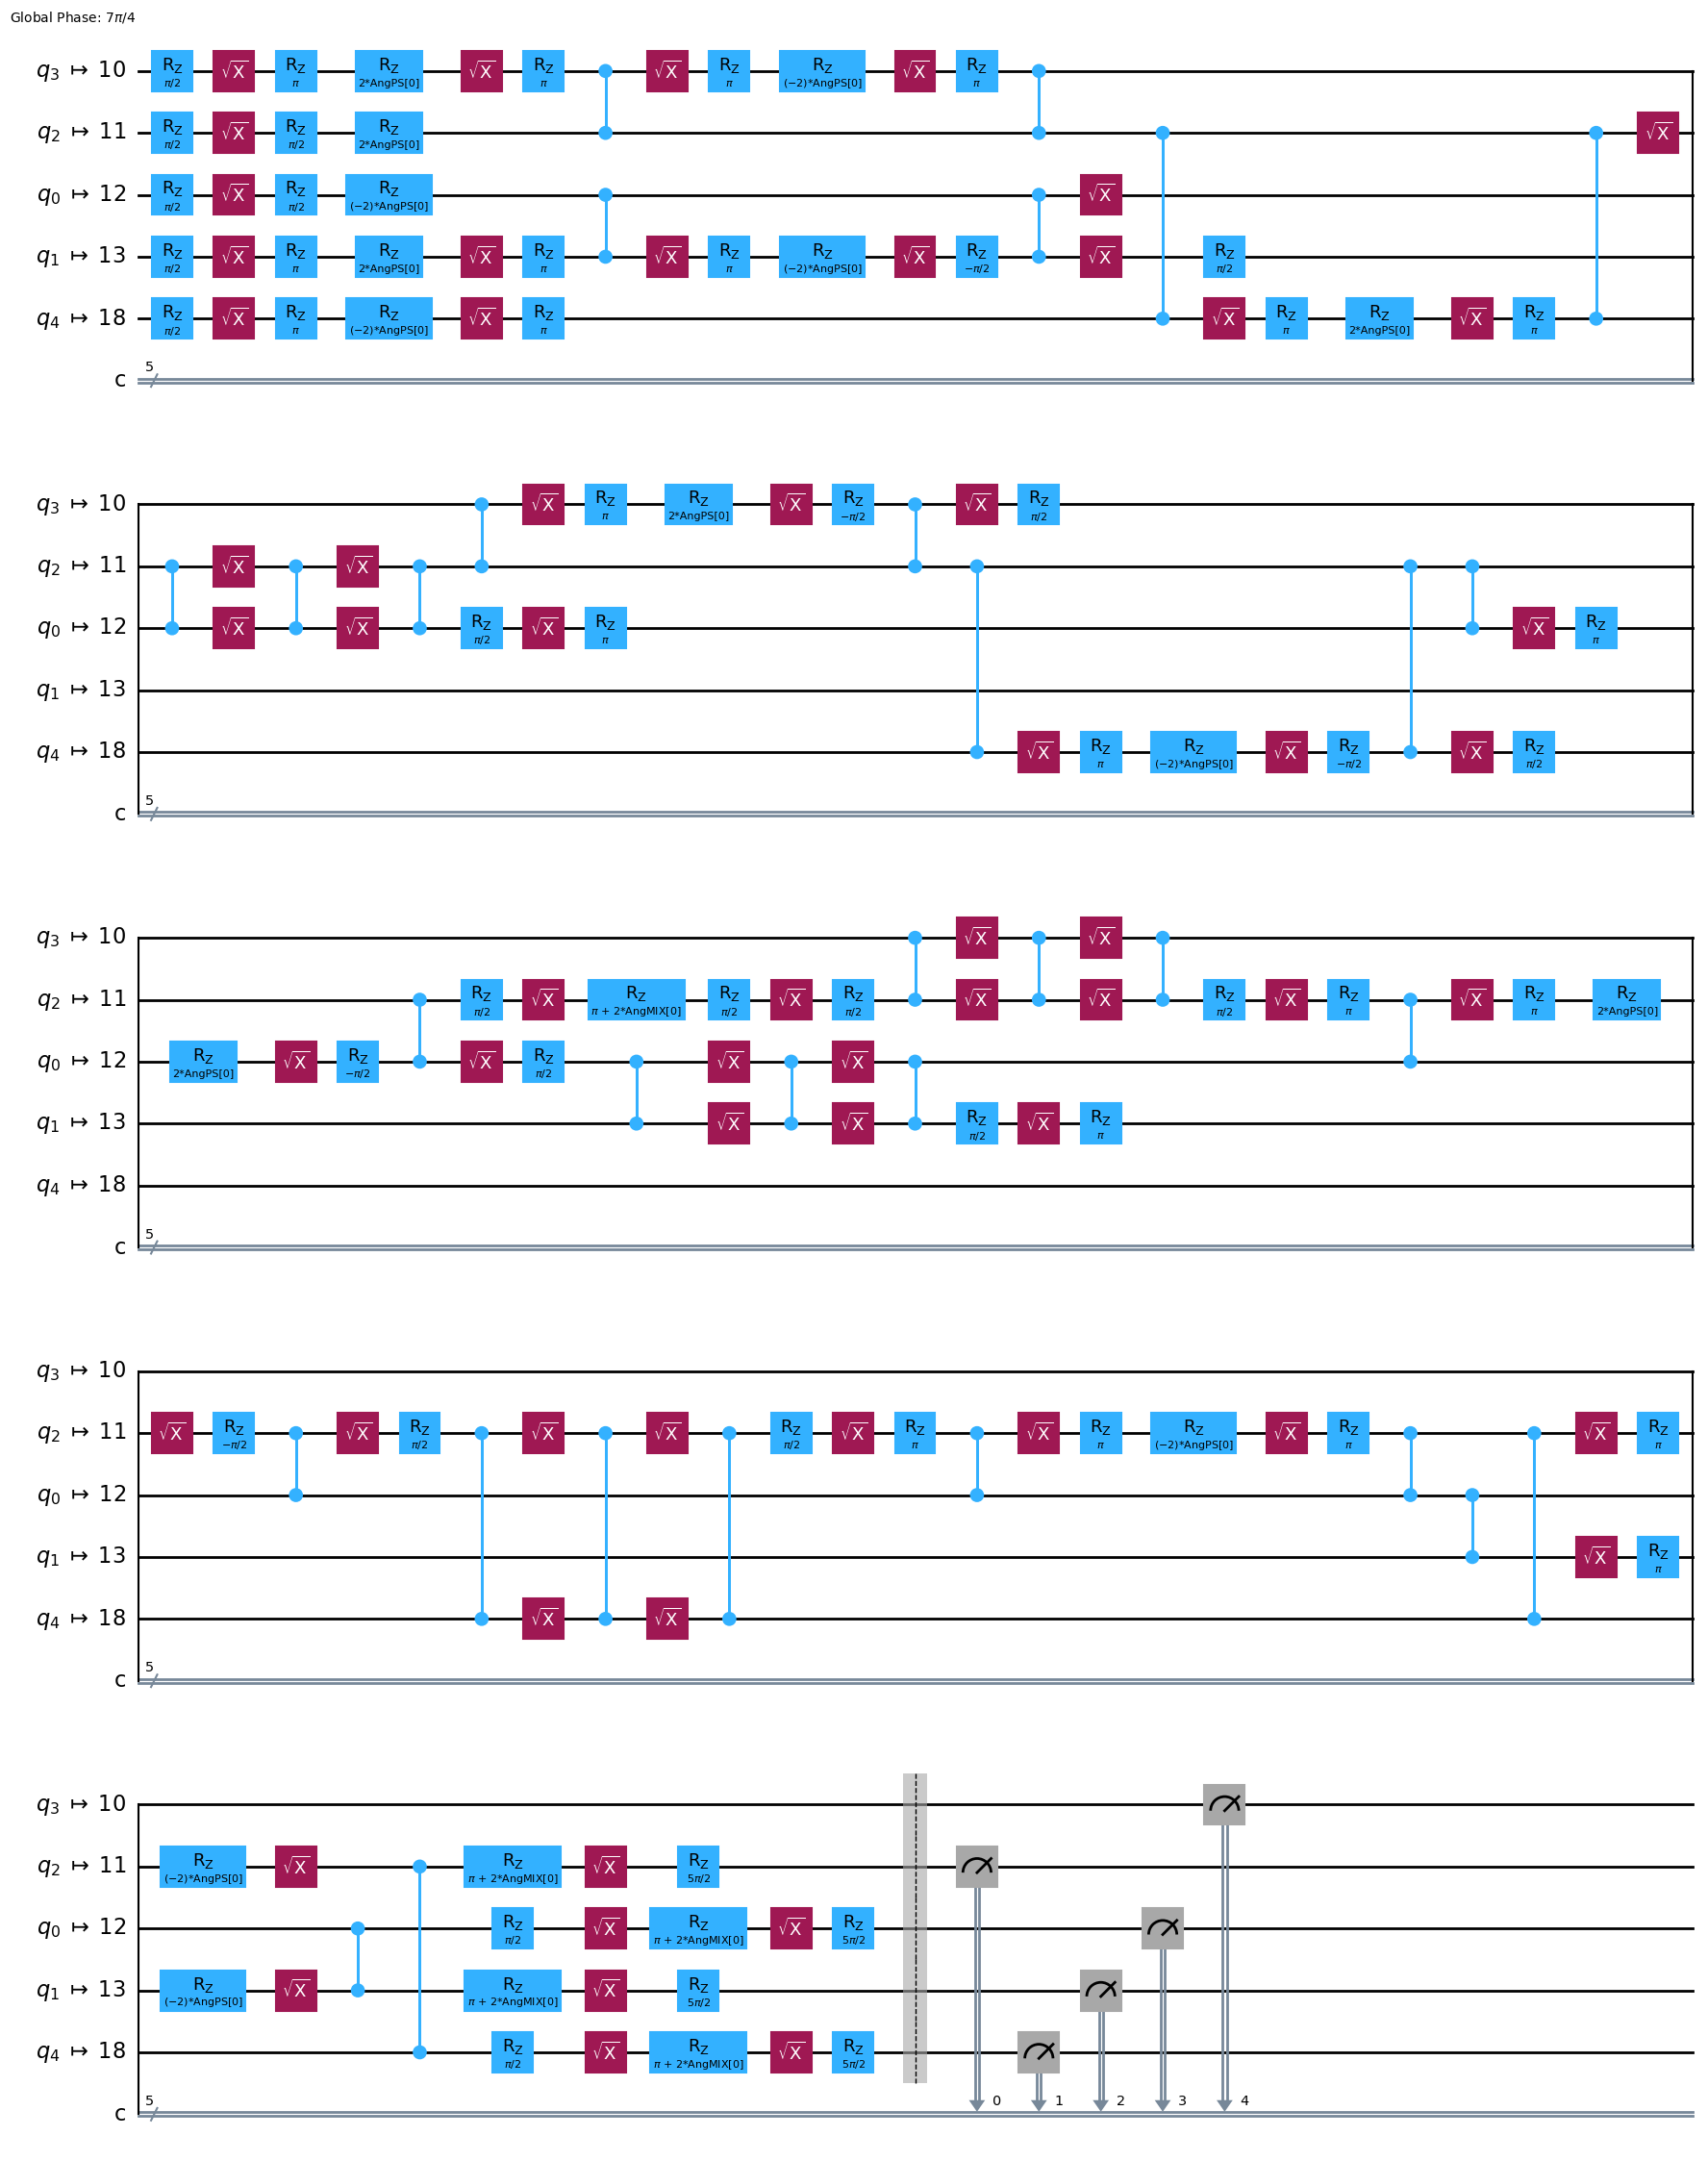

In [9]:
#Transpile circuit to ISA for given device.
#Note: if we run on 'aer' simulator, then this pass will not do anything
isa_circuit = qiskit_pass_manager.run(ansatz_circuit_LSN)
isa_circuit.draw('mpl')

### Now set the parameters to specific value

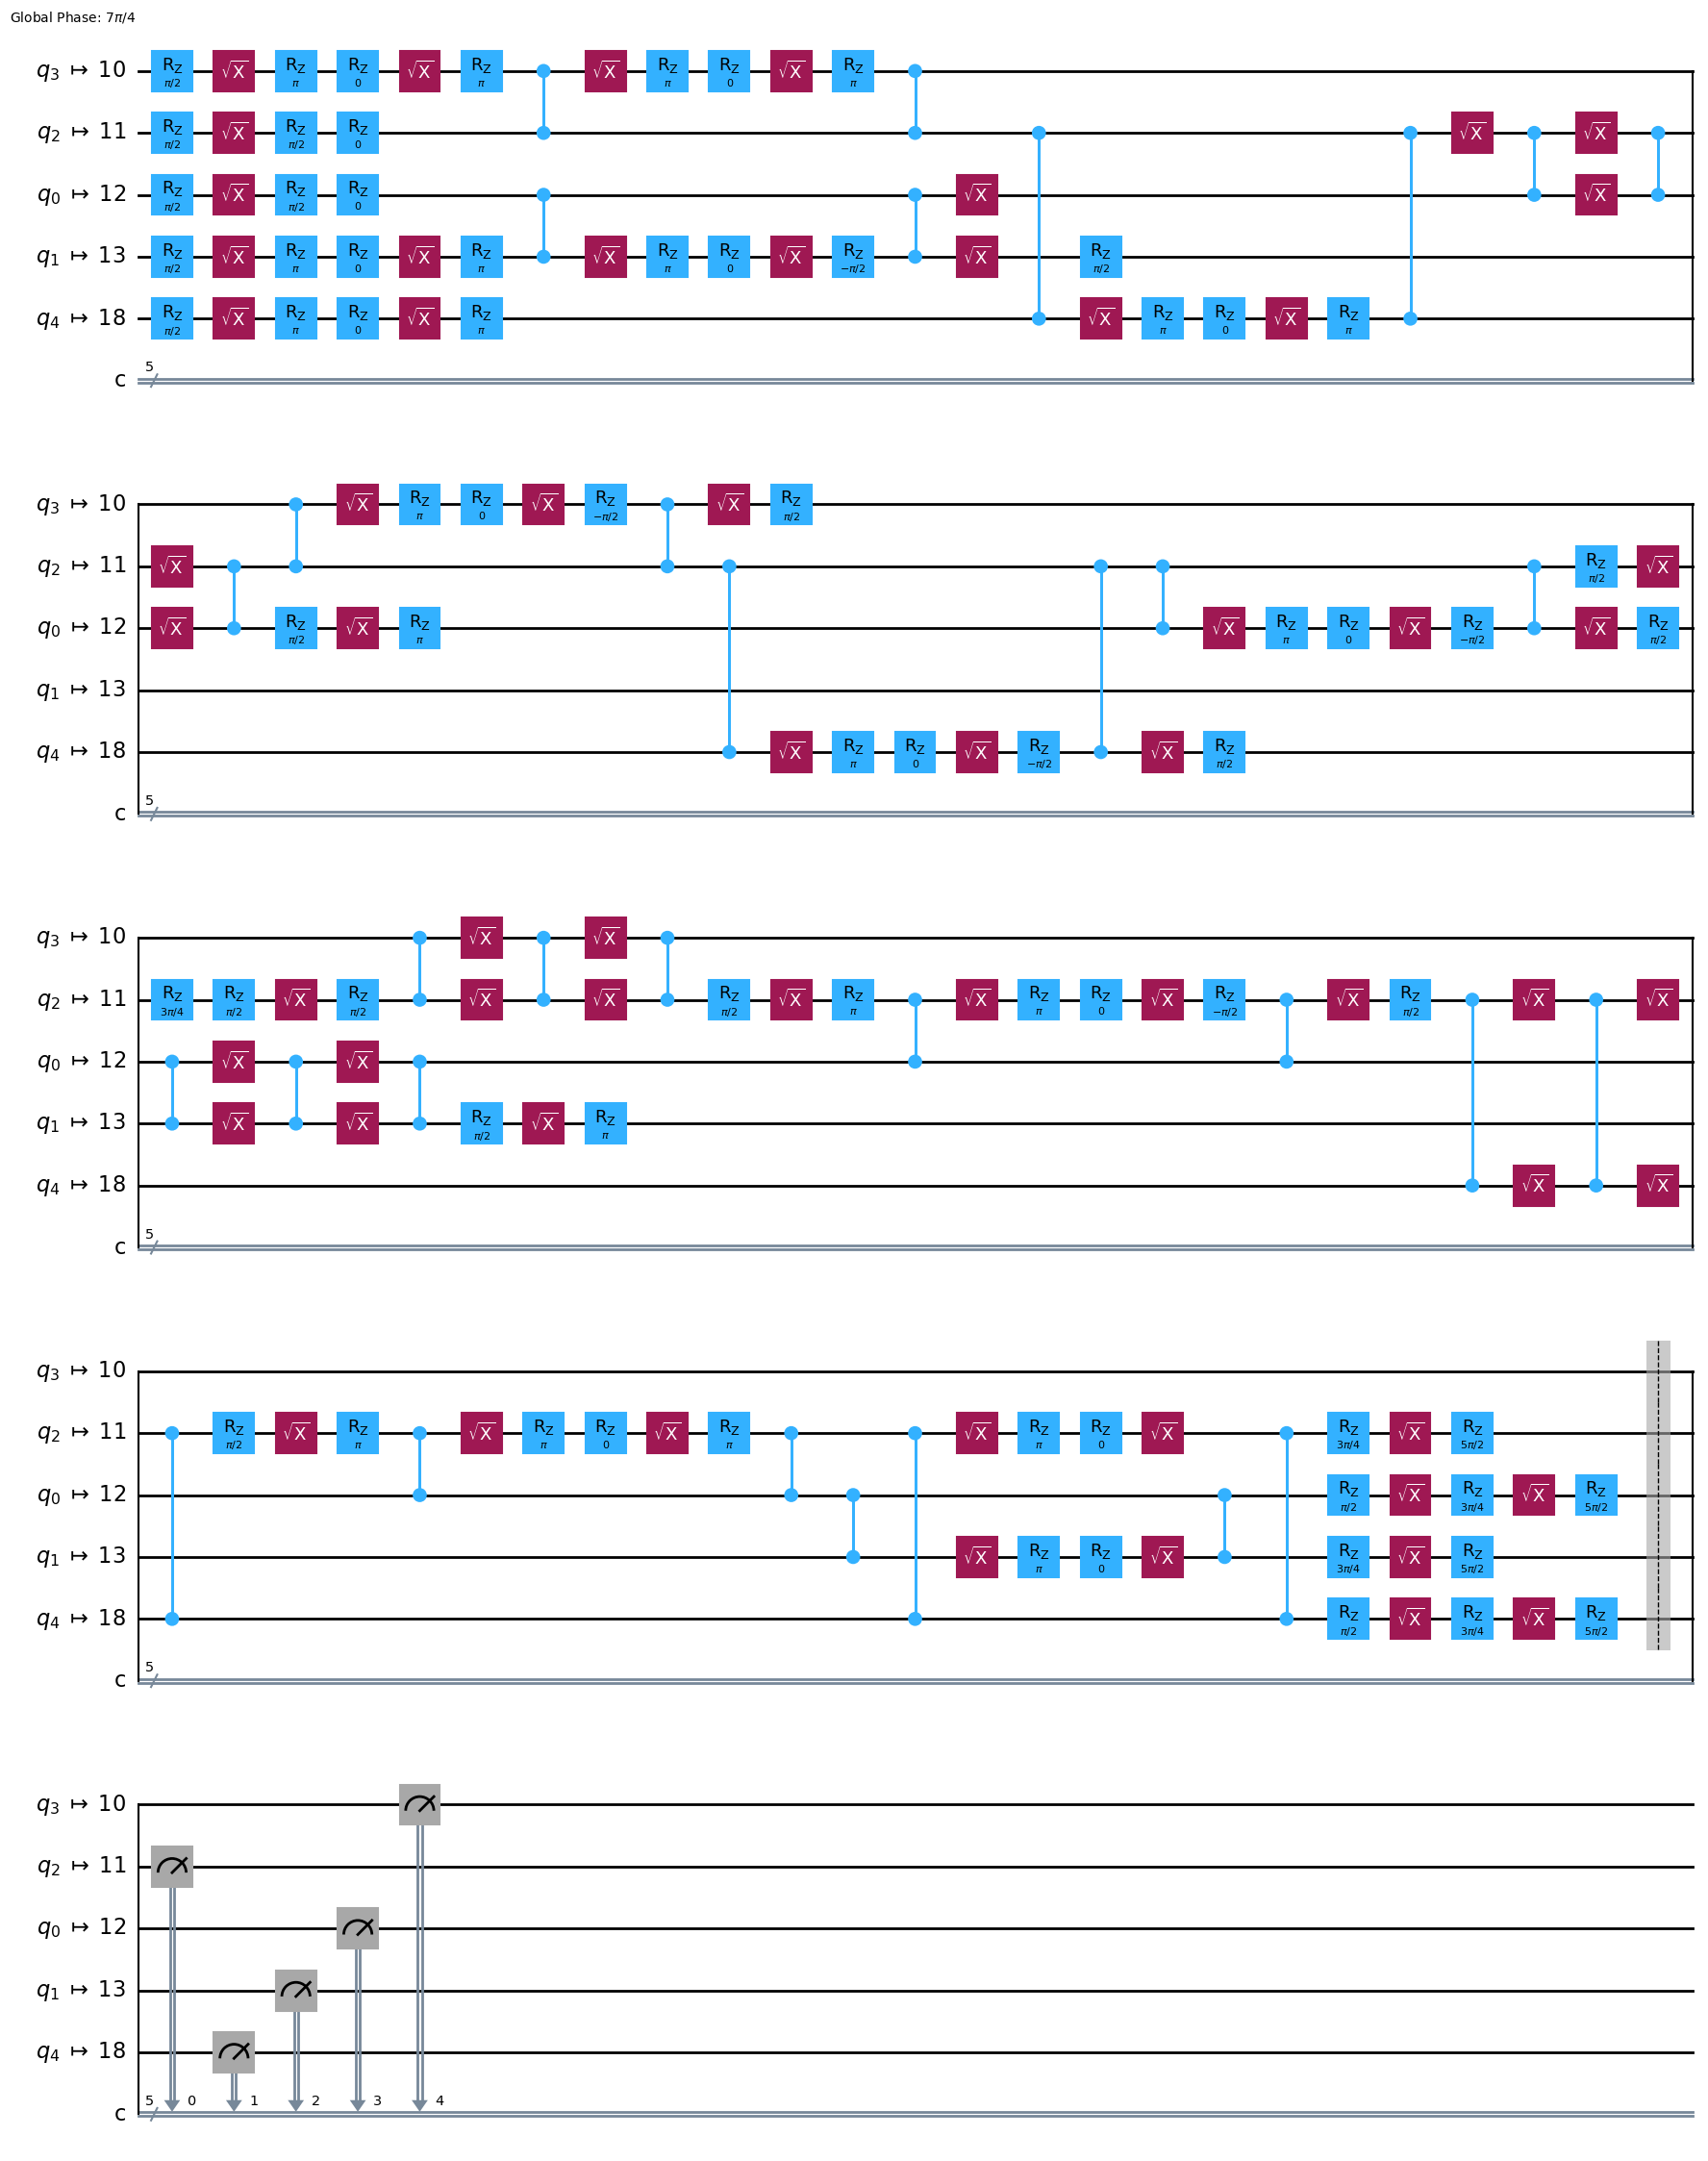

In [10]:
angles_phase_test = [0]
angles_mixer_test = [-np.pi / 8]

angles_dict = {ansatz_LSN.parameters[0]: angles_phase_test,
               ansatz_LSN.parameters[1]: angles_mixer_test}

isa_circuit_resolved = gate_builder.parameters_resolver(quantum_circuit=isa_circuit,
                                                        memory_map=angles_dict)
isa_circuit_resolved.draw('mpl')

### Run qiskit job

{(0, 0, 1, 1, 0): 2, (0, 1, 0, 0, 0): 1, (0, 1, 0, 1, 0): 1, (0, 1, 1, 1, 0): 1}


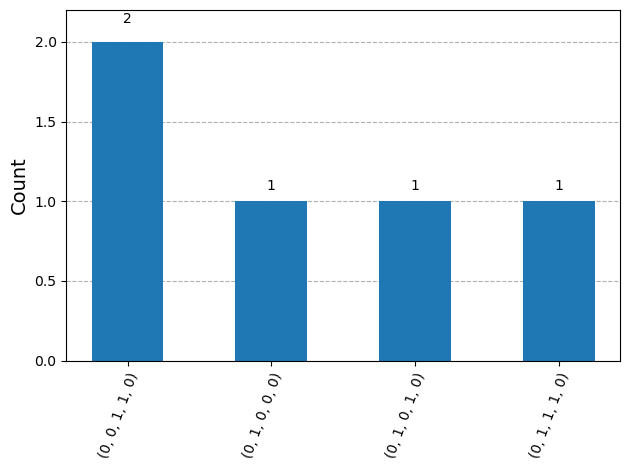

In [11]:

from qiskit import visualization as qiskit_vis
#import qiskit_aer

qiskit_sampler = bck_utils.create_qiskit_sampler(qiskit_backend=qiskit_backend,
                                                 simulation=True,
                                                 qiskit_sampler_options=None, #use defaults
                                                 session_ibm=None, #add if desired
                                                 override_to_noiseless_simulation=True, #remove default device's noise model
                                                 )


_success, job, results, df_job_metadata = bck_utils.attempt_to_run_qiskit_circuits(circuits_isa=[isa_circuit_resolved],
                                                                                   sampler_ibm=qiskit_sampler,
                                                                                   number_of_shots=5
                                                                                   )
if not _success:
    raise ValueError("Whoops, something went wrong!")

counts_dict = bck_utils.get_counts_from_sampler_result(sampler_results=results[0],
                                                       return_dict=True)
print(counts_dict)
qiskit_vis.plot_histogram(data=counts_dict)

### Wrapper for qiskit simulator

All the above operations can be done in a more convenient way using the wrapper for qiskit simulator.

In [12]:
from quapopt.optimization.QAOA.implementation.QAOARunnerQiskit import QAOARunnerQiskit

#just set up the whole simulator automatically
qaoa_simulator_qiskit = QAOARunnerQiskit(hamiltonian_phase=cost_hamiltonian,
                                         qiskit_pass_manager=qiskit_pass_manager,
                                         qiskit_backend=qiskit_backend,
                                         program_gate_builder=gate_builder,
                                         qubit_mapping_type=QubitMappingType.sabre,
                                         qaoa_depth=qaoa_depth,
                                         time_block_size=time_block_size,
                                         phase_separator_type=phase_separator_type,
                                         mixer_type=mixer_type,
                                         simulation=True,
                                         qiskit_sampler_options=None,
                                         session_ibm=None,
                                         noiseless_simulation=True,
                                         )

#returns the raw job results; but also bitstrings converted to the format used across repo (array of 0s and 1s)
job_object, bitstrings_array = qaoa_simulator_qiskit.run_qaoa(angles_PHASE=angles_phase_test,
                                                              angles_MIXER=angles_mixer_test,
                                                              number_of_samples=5)
bitstrings_array

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 1, 0]], dtype=int32)

### Wrapper for QAOA Sampler
* In the context of QAOA, we can wrap the simulator a bit more so it's a part of more abstract framework useful in further optimization.
* The "QAOARunnerSampler" is an abstract class that can be used to run the QAOA with different backends (here we will be interested mostly in qiskit though).
* The optimization is a bit more general -- a) we can optimize over ansatz for which phase is not the same as cost; b) we can optimize over multiple representations of the Hamiltonian (e.g., permutations or bitflip gauges); note that b) requires classical optimizer that can actually support it.


Mean energy: 0.0472
Best energy: -9.0
GS energy: -9.0


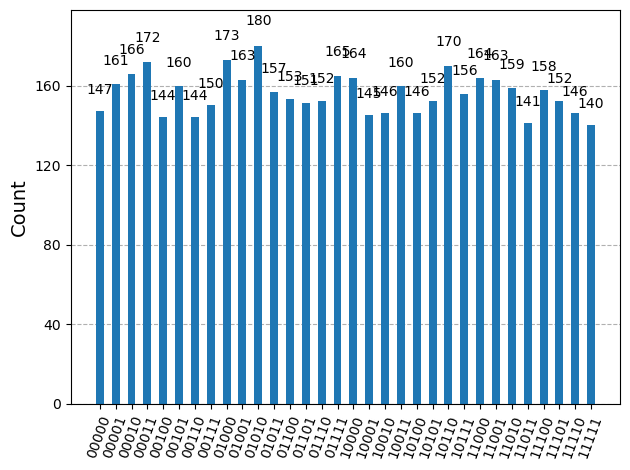

In [13]:
from quapopt.optimization.QAOA.implementation.QAOARunnerSampler import QAOARunnerSampler
#Set up the raw sampler with Hamiltonians as an input
qaoa_sampler = QAOARunnerSampler(
    hamiltonian_representations_cost=[cost_hamiltonian],
    hamiltonian_representations_phase=None,
    store_n_best_results=1,
    #this might be important in the future
    store_full_information_in_history=False,
    numpy_rng_sampling=None)

#Here we basically run the same thing as before but inside the class; so the ansatze are set up for possibly multiple cost Hamiltonians
qaoa_sampler.initialize_backend_qiskit(simulation=True,
                                                                              qiskit_backend=qiskit_backend,
                                       noiseless_simulation=True,

                                       qiskit_pass_manager=qiskit_pass_manager,
                                       program_gate_builder=gate_builder,
                                       qaoa_depth=qaoa_depth,
                                       time_block_size=time_block_size,
                                       phase_separator_type=phase_separator_type,
                                       mixer_type=mixer_type,
                                       qubit_indices_physical=None,
                                       classical_indices=None)
# qaoa_sampler.initialize_backend_qokit()

angles_input = list(angles_phase_test)+list(angles_mixer_test)
hamiltonian_representation_index_input = 0 #if we had more representations, we would have to specify which one to use here; if we only have one and we don't provide this argument, it is set to 0 by default
#Run the QAOA
#This returns an internal "result" object that stores some information about the run
result_ideal, qiskit_job_ideal = qaoa_sampler.run_qaoa(angles_input,
                                                       hamiltonian_representation_index_input,
                                                       qaoa_depth=qaoa_depth,
                                                       return_raw_result=True,
                                                       number_of_samples=5000)

print('Mean energy:', result_ideal.energy_mean)
print('Best energy:', result_ideal.energy_best)
print('GS energy:', ground_state_energy)

result = qiskit_job_ideal.result()[0]
# a bit of data conversion here
counts_dict_tuples = bck_utils.get_counts_from_bit_array(result.data.c,
                                                         return_dict=True)
counts_dict_str = {''.join(map(str, k)): v for k, v in counts_dict_tuples.items()}

qiskit_vis.plot_histogram(data=counts_dict_str)

### Add measurement noise

* We can add classical measurement noise to the simulation. Here we will emulate amplitude damping at the very end of the circuit.

Mean energy: 0.0472
Best energy: -9.0
GS energy: -9.0


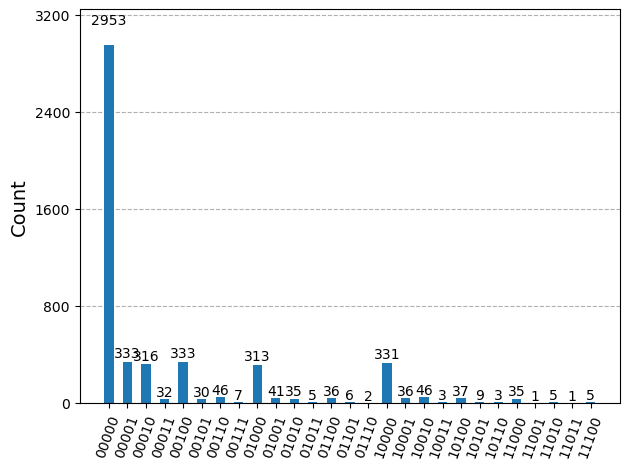

In [14]:
from quapopt.circuits.noise.simulation.ClassicalMeasurementNoiseSampler import ClassicalMeasurementNoiseSampler, \
    MeasurementNoiseType
from collections import Counter

# Fully asymmetric noise -- equivalent to amplitude damping at the end of the circuit
p_01 = 0.8
p_10 = None
CMNS = ClassicalMeasurementNoiseSampler(noise_type=MeasurementNoiseType.TP_1q_identical,
                                        noise_description={'p_01': p_01,
                                                           'p_10': p_10})

result_noisy, _ = qaoa_sampler.run_qaoa(angles_input,
                                        hamiltonian_representation_index_input,
                                        qaoa_depth=qaoa_depth,
                                        return_raw_result=True,
                                        number_of_samples=5000,
                                        measurement_noise=CMNS)

bitstrings_array_noisy = result_noisy.bitstrings_array
#alternative data conversion
bitstrings_histogram_noisy = Counter([''.join([str(s) for s in bts]) for bts in bitstrings_array_noisy])

print('Mean energy:', result_ideal.energy_mean)
print('Best energy:', result_ideal.energy_best)
print('GS energy:', ground_state_energy)

qiskit_vis.plot_histogram(data=bitstrings_histogram_noisy)
